# Examining GNMA II Pool-Level Data

Now that it's all in one big H5 file.

JPM model is pool-level. Let's take a look at the GNM pool-level data. This still only starts in 2012.

It's far more structured than the loan-level data. I have 

## Factors w/ Necessary fields
    * Curve at Origination: 
        * pools.as_of_date, pools.pool_issue_date
        * monthly history of the yield curve. (where "Yield Curve" == 10Y-2Y spread)
    * Spread at Origination: median WAC of pool vs. average WAC of all pools in month
        * WAC
    * Seasonality: Expect higher prepayments in April-August (prefer summer move minus 1M lag)
        * as_of_date
    * Loan size
        * pool_upb? purchase_upb? What's the difference?
    * Home Price Appreciation
        * first_msa, first_pct_upb, second_msa, second_pct_upb, etc.
        * MSA code concordance
        * CPI
    * Burnout: weighted sum of monthly NPV of savings from refinancing
        * monthly incentives, w/ weights declining on accumulated home equity (home price appreciation + LTV)
    * Turnover: Home Price Appreciation, "seasoning ramp", lock-in, seasonality
        * Seasoning ramp: half-sigmoid function approaching 1 at ~ 11 months' WALA
        * Lock-in: the effect of rising interest rates or negative equity. Current mtg rate / WAC. Must be < 1.0
        * Seasonality: X-11/12 ARIMA per month. They say Census Bureau, so it's Demeter.
    * Incentive: purchase mtg rate - function of 15Y and 30Y rates, WALA.
        * 15Y mtg rate, 30Y mtg rate, WALA
    * MIP-related
        * f(upfront MIP, WALA) (upfront MIP will be refunded on amortized basis)
        * f(HPA) (extra incentive to refinance to end monthly MIP)
    * CPR (this is the endo)
        * % of UPB of loans paid off (in Various table) +, I guess, repurchased, foreclosed, etc., in same table.
    
JPM estimated separately by WALA. But WALA is an input to the model, so I'm not sure why. Could do it their way, could add a hierarchy.

It might be interesting to look at some WAC distributions, since they give min, max, and quartiles.

I plan to sample from the total set, so I'll need a function that gathers data across tables, and from some outside sources.

In [1]:
import tables
import pandas as pd
import ggplot
import numpy as np
path = "/data/prepayments/GNM_II_pool.h5"

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Add per-pool index (only need to do this once)

In [8]:
h5file = tables.open_file(path, "a")

h5file.root.pools.cols.cusip.create_index(optlevel=9, kind='full')
h5file.root.pools.cols.pool_number.create_index(optlevel=9, kind='full')
h5file.root.variouses.cols.pool_number.create_index(optlevel=9, kind='full')
h5file.root.msas.cols.pool_number.create_index(optlevel=9, kind='full')

h5file.close()

In [9]:
h5file = tables.open_file(path,"r")

In [4]:
h5file.root.pools

/pools (Table(14151801,), shuffle, blosc(9)) 'pools'
  description := {
  "aols": Int64Col(shape=(), dflt=0, pos=0),
  "as_of_date": Time32Col(shape=(), dflt=0, pos=1),
  "cusip": StringCol(itemsize=9, shape=(), dflt='', pos=2),
  "few_units_number_of_loans": Int32Col(shape=(), dflt=0, pos=3),
  "few_units_pct_of_upb": Int32Col(shape=(), dflt=0, pos=4),
  "few_units_upb": Int64Col(shape=(), dflt=0, pos=5),
  "first_quartile_aols_q1": Int64Col(shape=(), dflt=0, pos=6),
  "first_quartile_cltv_q1": Int16Col(shape=(), dflt=0, pos=7),
  "first_quartile_ltv_q1": Int16Col(shape=(), dflt=0, pos=8),
  "first_quartile_wac_q1": Int32Col(shape=(), dflt=0, pos=9),
  "first_quartile_wagm_q1": Int32Col(shape=(), dflt=0, pos=10),
  "first_quartile_wala_q1": Int16Col(shape=(), dflt=0, pos=11),
  "first_quartile_waolt_q1": Int16Col(shape=(), dflt=0, pos=12),
  "first_quartile_warm_q1": Int16Col(shape=(), dflt=0, pos=13),
  "hamp_modified_number_of_loans": Int32Col(shape=(), dflt=0, pos=14),
  "hamp_modi

1.4M rows over 106 months is a minimum of ~ 13000 pools we're looking at.

In [5]:
h5file.root.pools[1]

(7331667, 1328072400, '36202AAF4', 0, 0, 0, 7655000, 999, 100, 8000, 99999, 240, 360, 120, 0, 0, 0, 18000, 'Multiple Issuers                        ', 9999, 0, 0, 0, 0, 0, 0, 0, 8930000, 999, 100, 8000, 99999, 240, 360, 120, 8930000, 999, 100, 8000, 99999, 240, 360, 120, 5410000, 999, 90, 8000, 99999, 239, 360, 116, 0, 0, 0, 3, 3, 10000, 13157290, 254108200, 18000, 2, 709963200, 1653019200, '000006', 'SF', 0, 0, 0, 0, 0, 0, 0, 3, 10000, 13157290, 7000, 9999, 8930000, 999, 100, 8000, 99999, 240, 360, 120, 8000, 99999, 240, 360, 119, 999, 0, 97)

In [6]:
for i,record in enumerate(h5file.root.pools.where('cusip == "36202AAF4"')):
    print "\t".join([str(i), 
                     '{:%Y-%m}'.format(datetime.datetime.fromtimestamp(record['as_of_date'])),
                     '{:%Y-%m}'.format(datetime.datetime.fromtimestamp(record['pool_issue_date'])),
                     str(record['wac']),
                     str(record['pool_upb']), str(record['purchase_upb']),
                    str(record['wala']), str(record['median_ltv_q2']), str(record['minimum_ltv_q0'])])

0	2012-02	1992-07	8000	0	0	240	100	90
1	2012-03	1992-07	8000	0	0	241	100	90
2	2012-04	1992-07	8000	0	0	242	100	90
3	2012-05	1992-07	8000	0	0	243	100	90
4	2012-06	1992-07	8000	0	0	244	100	90
5	2012-07	1992-07	8000	12802452	0	245	100	90
6	2012-08	1992-07	8000	0	0	246	100	90
7	2012-09	1992-07	8000	12675629	0	247	100	90
8	2012-10	1992-07	8000	12567767	0	248	100	90
9	2012-11	1992-07	8000	12490161	0	249	100	90
10	2012-12	1992-07	8000	12412037	0	250	100	90
11	2013-01	1992-07	8000	12333392	0	251	100	90
12	2013-02	1992-07	8000	12254223	0	252	100	90
13	2013-03	1992-07	8000	12174526	0	253	100	90
14	2013-04	1992-07	8000	12094298	0	254	100	90
15	2013-05	1992-07	8000	12013535	0	255	100	90
16	2013-06	1992-07	8000	11932233	0	256	100	90
17	2013-07	1992-07	8000	11850390	0	257	100	90
18	2013-08	1992-07	8000	11768000	0	258	100	90
19	2013-09	1992-07	8000	11685062	0	259	100	90
20	2013-10	1992-07	8000	11601177	0	260	100	90
21	2013-11	1992-07	8000	11514508	0	261	100	90
22	2013-12	1992-07	8000	11429880	0	262	1

In [10]:
for i,record in enumerate(h5file.root.msas.where('cusip == "36202AAF4"')):
    print "\t".join([str(i), 
                     '{:%Y-%m}'.format(datetime.datetime.fromtimestamp(record['as_of_date'])),
                     str(record['first_msa']),
                     str(record['first_pct_upb']), str(record['second_msa']),
                    str(record['second_pct_upb'])])

0	2012-02	37980	4100	47900	3428
1	2012-03	37980	4094	47900	3422
2	2012-04	37980	4095	47900	3422
3	2012-05	37980	4095	47900	3421
4	2012-06	37980	4096	47900	3420
5	2012-07	37980	4096	47900	3419
6	2012-08	37980	4097	47900	3419
7	2012-09	37980	4113	47900	3407
8	2012-10	37980	4099	47900	3414
9	2012-11	37980	4100	47900	3413
10	2012-12	37980	4100	47900	3413
11	2013-01	37980	4101	47900	3412
12	2013-02	37980	4101	47900	3411
13	2013-03	37980	4102	47900	3410
14	2013-04	37980	4102	47900	3409
15	2013-05	37980	4103	47900	3408
16	2013-06	37980	4103	47900	3407
17	2013-07	37980	4104	47900	3406
18	2013-08	37980	4105	47900	3405
19	2013-09	37980	4105	47900	3404
20	2013-10	37980	4106	47900	3403
21	2013-11	37980	4105	47900	3403
22	2013-12	37980	4106	47900	3402
23	2014-01	37980	4106	47900	3400
24	2014-02	37980	4107	47900	3399
25	2014-03	37980	4108	47900	3398
26	2014-04	37980	4108	47900	3397
27	2014-05	37980	4109	47900	3396
28	2014-06	37980	4110	47900	3394
29	2014-07	47900	5761	26420	4239
30	2014-08	47900	576

In [7]:
msas = [x for x in h5file.root.msas.col("first_msa")]

In [8]:
len(msas)

11266861

In [9]:
msas = set(msas)

In [10]:
len(msas)

963

In [11]:
msas

{0,
 10020,
 10100,
 10140,
 10180,
 10220,
 10260,
 10300,
 10380,
 10420,
 10460,
 10500,
 10540,
 10580,
 10620,
 10660,
 10700,
 10740,
 10760,
 10780,
 10820,
 10860,
 10880,
 10900,
 10940,
 10980,
 11020,
 11060,
 11100,
 11140,
 11180,
 11220,
 11260,
 11300,
 11340,
 11380,
 11420,
 11460,
 11500,
 11540,
 11580,
 11620,
 11660,
 11700,
 11740,
 11780,
 11820,
 11860,
 11900,
 11940,
 11980,
 12020,
 12060,
 12100,
 12140,
 12180,
 12220,
 12260,
 12300,
 12380,
 12420,
 12460,
 12540,
 12580,
 12620,
 12660,
 12700,
 12740,
 12780,
 12820,
 12860,
 12900,
 12940,
 12980,
 13020,
 13060,
 13100,
 13140,
 13180,
 13220,
 13260,
 13300,
 13340,
 13380,
 13420,
 13460,
 13500,
 13540,
 13620,
 13660,
 13700,
 13740,
 13780,
 13820,
 13860,
 13900,
 13940,
 13980,
 14020,
 14060,
 14100,
 14140,
 14180,
 14220,
 14260,
 14300,
 14340,
 14380,
 14420,
 14460,
 14500,
 14540,
 14580,
 14620,
 14660,
 14700,
 14740,
 14780,
 14820,
 14860,
 14940,
 15020,
 15060,
 15100,
 15140,
 151

In [13]:
for record in h5file.root.msas.where("first_msa > 99999"):
    print record
    break

In [119]:
msas = np.array([h5file.root.msas[i]["first_pct_upb"] 
                 for i in np.random.choice(h5file.root.msas.shape[0], 10000)])

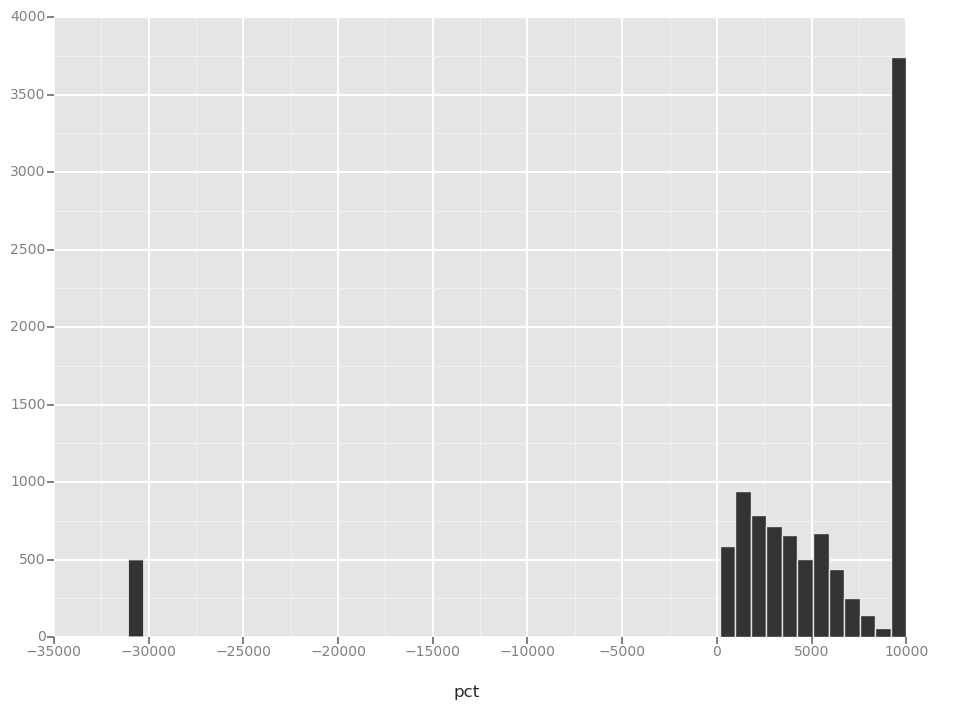

<ggplot: (8763010131065)>

In [120]:
ggplot.ggplot(pd.DataFrame({'pct':msas}), ggplot.aes(x='pct')) + ggplot.geom_histogram(bins=50)

uh-oh. what's with those -300% records? Are they all older, or newer, meaning a misalignment due to change of record spec?

In [127]:
msas = []
for record in h5file.root.msas.where("first_pct_upb < 0"):
    msas.append(('{:%Y-%m}'.format(datetime.datetime.fromtimestamp(record['as_of_date'])),
                 record['first_pct_upb']))

In [128]:
msas = pd.DataFrame.from_records(msas, columns=['dt','pct'])

In [130]:
msas.head()

,dt,pct
0,2012-02,-31073
1,2012-02,-31073
2,2012-02,-31073
3,2012-02,-31073
4,2012-02,-31073


In [131]:
msas.tail()

,dt,pct
724016,2016-12,-31073
724017,2016-12,-31073
724018,2016-12,-31073
724019,2016-12,-31073
724020,2016-12,-31073


Nope. What does -310.73% mean?

In [134]:
for record in h5file.root.msas.where("first_pct_upb < 0"):
    print record.fetch_all_fields()
    break

(1328072400, '36202AAQ0', 99999, 999999, -31073, 9999999999999, 99999, 999999, -31073, 9999999999999, 99999, 999999, -31073, 9999999999999, 99999, 999999, -31073, 9999999999999, 9999, 99999, 999999, -31073, 9999999999999, 1, 10000, 904170, 2, '000015', 'SF', 99999, 999999, -31073, 9999999999999, 99999, 999999, -31073, 9999999999999, 99999, 999999, -31073, 9999999999999, 99999, 999999, -31073, 9999999999999, 99999, 999999, -31073, 9999999999999)


What a useless record. 

-31073 is the overflow for an int16col that's fed 99999. Probably should have handled all nines in the parser code. I'm going to change that now.

I'll need to go through every record and replace -31073 with 0. Probably faster to do that on current records than recreate from scratch.

... on second thought, we're better off distinguishing 0 and "NA".

In [135]:
'{:%Y-%m}'.format(datetime.datetime.fromtimestamp(1328072400))

'2012-02'

# What do WACs look like?

In [14]:
import numpy as np

In [15]:
h5file.root.pools.shape

(14151801,)

In [16]:
sample_indexes = np.random.choice(a=h5file.root.pools.shape[0], replace=False, size=10000)

In [24]:
sample_wacs = [h5file.root.pools[row]['wac'] for row in sample_indexes]

In [25]:
sample_wacs = [x for x in sample_wacs if x < 99999]

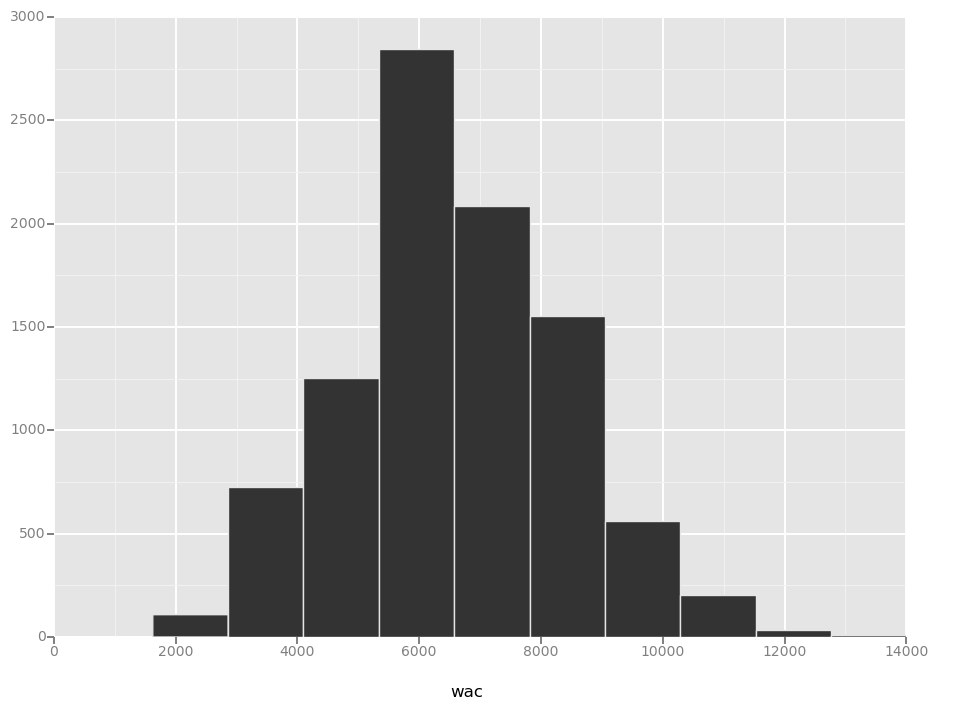

<ggplot: (8763100406013)>

In [26]:
ggplot.ggplot(pd.DataFrame({'wac':sample_wacs}), ggplot.aes(x='wac')) + ggplot.geom_histogram()

So, there are records with WAC of 99,999. What was wrong with 0 or '' if data is missing?

## Loan Size

We have pool_upb and purchase_upb. What's the difference? Presumably pool_upb is varying over time.

In [31]:
import seaborn as sns

In [27]:
h5file.root.pools[50000]

(5720600, 1328072400, '36224GN95', 0, 0, 0, 5720600, 999, 95, 99999, 99999, 235, 360, 116, 0, 0, 0, 18000, 'Bank Of America, Na                     ', 3907, 0, 0, 0, 0, 0, 0, 0, 5720600, 999, 95, 99999, 99999, 235, 360, 116, 5720600, 999, 95, 99999, 99999, 235, 360, 116, 5720600, 999, 95, 99999, 99999, 235, 360, 116, 0, 0, 0, 1, 1, 10000, 3466493, 800732900, 18000, 0, 712641600, 1660536000, '328116', 'SF', 0, 0, 0, 0, 1, 10000, 3466493, 0, 0, 0, 8000, 9999, 5720600, 999, 95, 99999, 99999, 235, 360, 116, 8500, 99999, 235, 360, 116, 999, 0, 95)

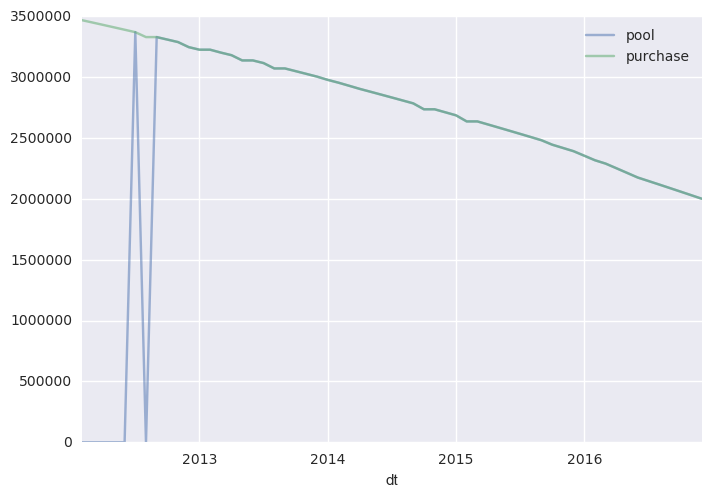

In [33]:
loan_size = pd.DataFrame.from_records([(datetime.datetime.fromtimestamp(record['as_of_date']),
                                      record['pool_upb'], record['purchase_upb']) 
                                       for record in h5file.root.pools.where("cusip == '36224GN95'")],
                                     index='dt', columns=['dt','pool','purchase'])
loan_size.plot(alpha=0.5)

... no difference, then. Try some others. I'll randomly sample from a population of CUSIPs.

In [34]:
cusips = set([h5file.root.pools[row]['cusip'] for row in sample_indexes])

In [35]:
len(cusips)

9786

In [58]:
str_where = "(cusip == '{}') & (pool_upb > 0) & (purchase_upb > 0)"
loan_size = pd.Panel({cusip:pd.DataFrame.from_records([
                            (datetime.datetime.fromtimestamp(record['as_of_date']),
                            record['pool_upb'], record['purchase_upb']) 
                            for record in h5file.root.pools.where(str_where.format(cusip))],
                                     index='dt', columns=['dt','pool','purchase'])
                      for cusip in cusips})
loan_size

<class 'pandas.core.panel.Panel'>
Dimensions: 9786 (items) x 54 (major_axis) x 2 (minor_axis)
Items axis: 36176A7D5 to 36297KZL8
Major_axis axis: 2012-07-01 00:00:00 to 2016-12-01 00:00:00
Minor_axis axis: pool to purchase

In [59]:
jim = loan_size.swapaxes('minor','items').to_frame().reset_index()

In [60]:
jim.head()

,dt,minor,pool,purchase
0,2012-07-01,36176A7D5,5.92016e+07,5.92016e+07
1,2012-07-01,36176ACB3,1.2766e+08,1.16725e+08
2,2012-07-01,36176AFG9,1.99884e+09,1.22214e+08
3,2012-07-01,36176AM71,2.422e+07,2.422e+07
4,2012-07-01,36176ANA3,5.14713e+07,5.14713e+07


In [61]:
jim['ratio'] = jim.purchase / jim.pool
jim.head()

,dt,minor,pool,purchase,ratio
0,2012-07-01,36176A7D5,5.92016e+07,5.92016e+07,1
1,2012-07-01,36176ACB3,1.2766e+08,1.16725e+08,0.914343
2,2012-07-01,36176AFG9,1.99884e+09,1.22214e+08,0.0611424
3,2012-07-01,36176AM71,2.422e+07,2.422e+07,1
4,2012-07-01,36176ANA3,5.14713e+07,5.14713e+07,1


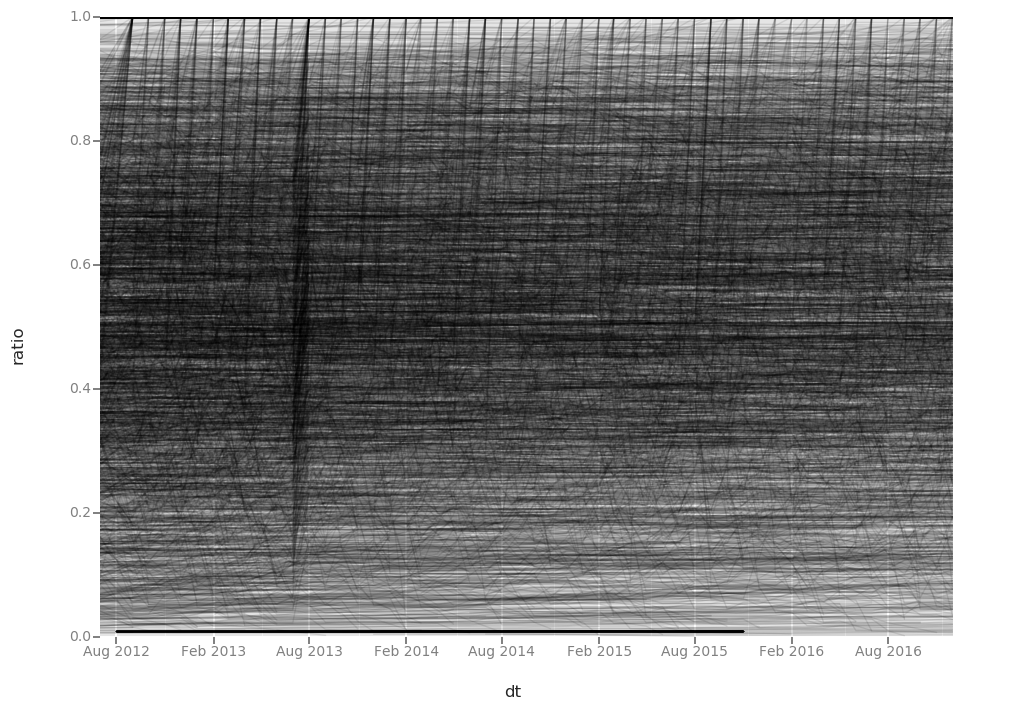

<ggplot: (8763046365773)>

In [69]:
ggplot.ggplot(jim,ggplot.aes(x='dt', y='ratio', col="minor"))+ggplot.geom_line(alpha=0.1)

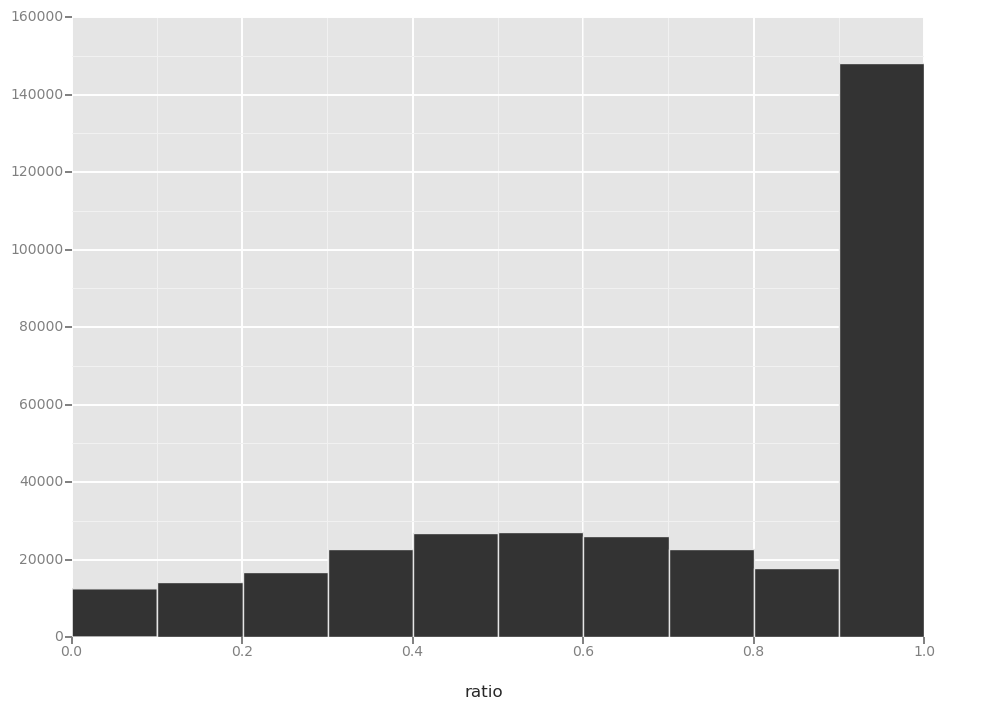

<ggplot: (8763045775261)>

In [66]:
ggplot.ggplot(jim, ggplot.aes(x='ratio')) + ggplot.geom_histogram()

In [70]:
del(loan_size)
del(jim)

... actually, I should just use Average Original Loan Size

In [71]:
jim = h5file.root.pools[0]

In [95]:
jim = [x['aols']/100. for x in h5file.root.pools.where("aols < 99999999")]

In [97]:
jim = pd.np.asarray(jim)

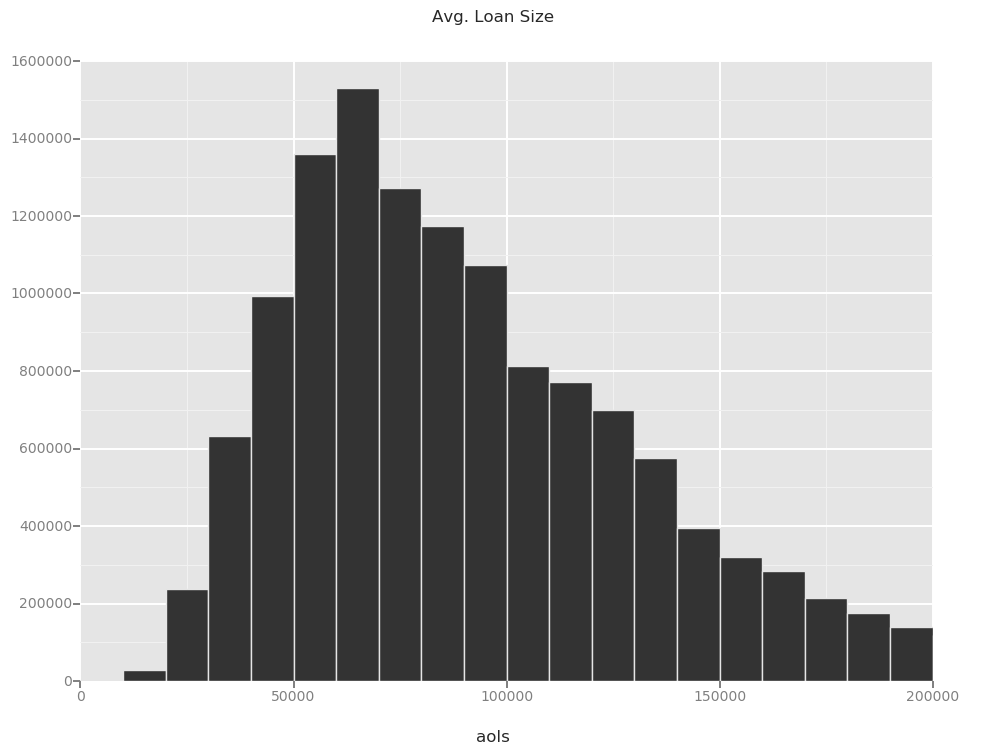

<ggplot: (8763009751413)>

In [102]:
p = ggplot.ggplot(pd.DataFrame({'aols':jim}),ggplot.aes(x='aols'))
p = p + ggplot.geom_histogram(bins=100) + ggplot.ggtitle("Avg. Loan Size")
p + ggplot.xlim(high=200000)

Goes up to 600000. JPM seems to have them binned, but could do log space, I guess.

## CATO

Yield Curve spread. Needs WALA

In [103]:
jim = h5file.root.pools.col("wala")
max(jim)

999

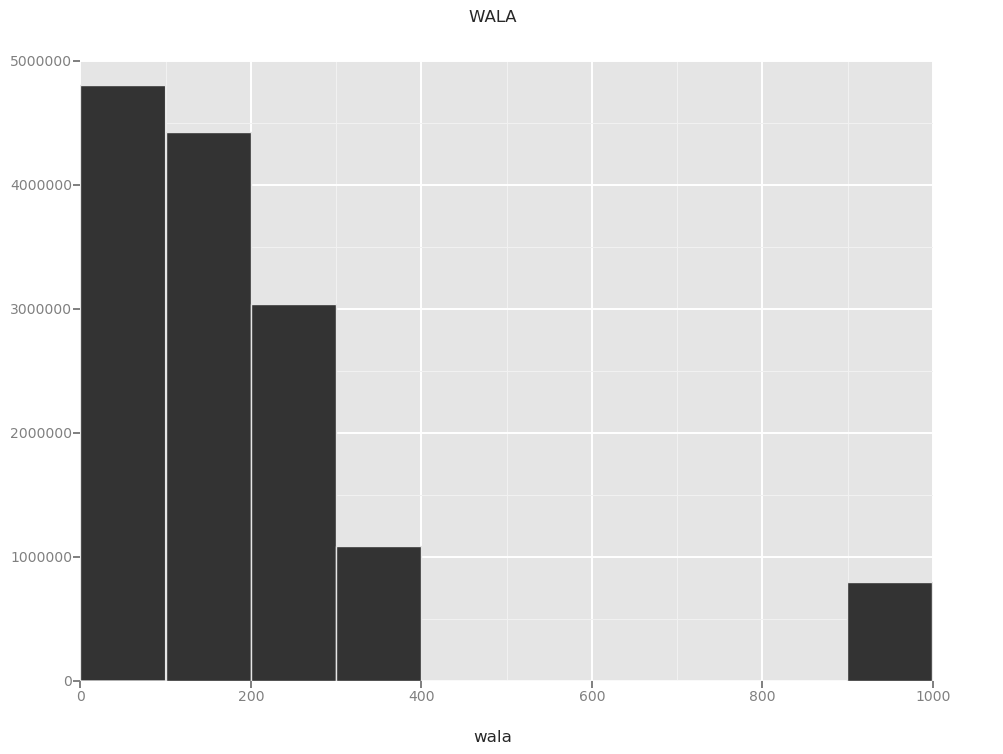

<ggplot: (8763010137369)>

In [106]:
ggplot.ggplot(pd.DataFrame({'wala':jim}), ggplot.aes(x="wala")) + ggplot.geom_histogram() + ggplot.ggtitle("WALA")

In [107]:
max([x for x in jim if x < 999])

360

30 years.

## Home Price Appreciation

Needs home price indexes, WALA, CPI, and MSA data.

30 years of data from 2010 means 1980. Case-Schiller starts in 1987, but Schiller has monthly data back to 1953 on his website: http://www.econ.yale.edu/~shiller/data.htm